In [23]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *

sampling_indices = (3, 4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate many objects in parallel

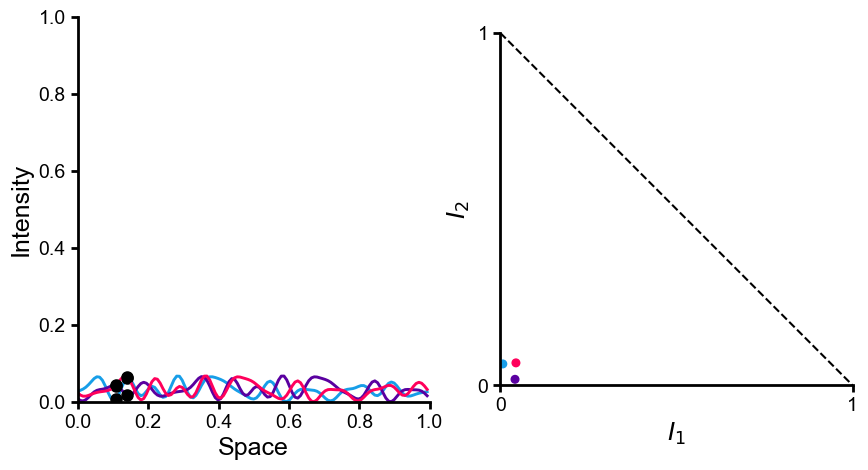

In [2]:
n_objects = 20
objects = np.array([sample_amplitude_object('delta') for i in range(n_objects)])

# generate random convolution kernel
random_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())
conv_mat = make_convolutional_encoder(random_kernel)

output_signals = objects @ conv_mat.T 


sampling_indices = (3, 4)
num_to_plot = 3

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_spatial_coordinates(ax[0], output_signals[:num_to_plot], sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1], output_signals[:num_to_plot], sample_point_indices=sampling_indices, differentiate_colors=True)

## Show example objects

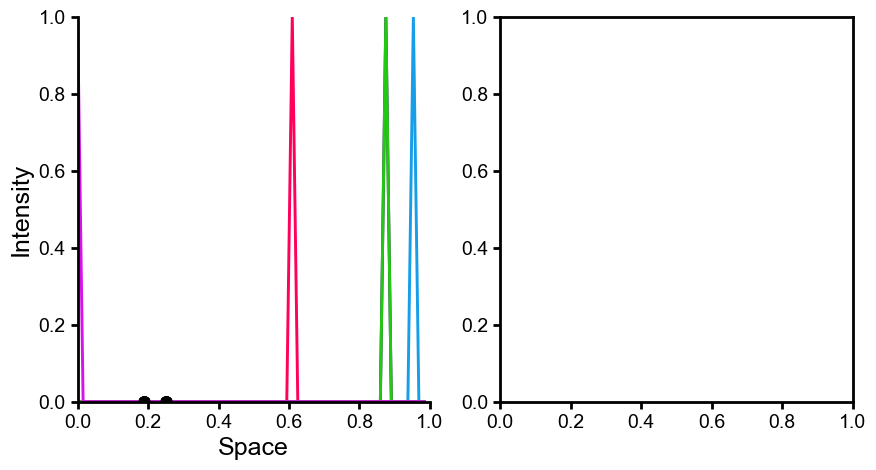

In [2]:
n_objects = 5
objects = np.array([sample_amplitude_object('delta') for i in range(n_objects)])
# objects = np.array([sample_amplitude_object('sinusoid', sin_freq_range=(9, 10)) for i in range(n_objects)])

# plot all the objects
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_spatial_coordinates(ax[0], objects, sample_point_indices=sampling_indices, plot_lim=1)

# Optimize an encoder based on entropy as a loss function

initial loss 292.9349902663107


Text(0.5, 1.0, 'Object')

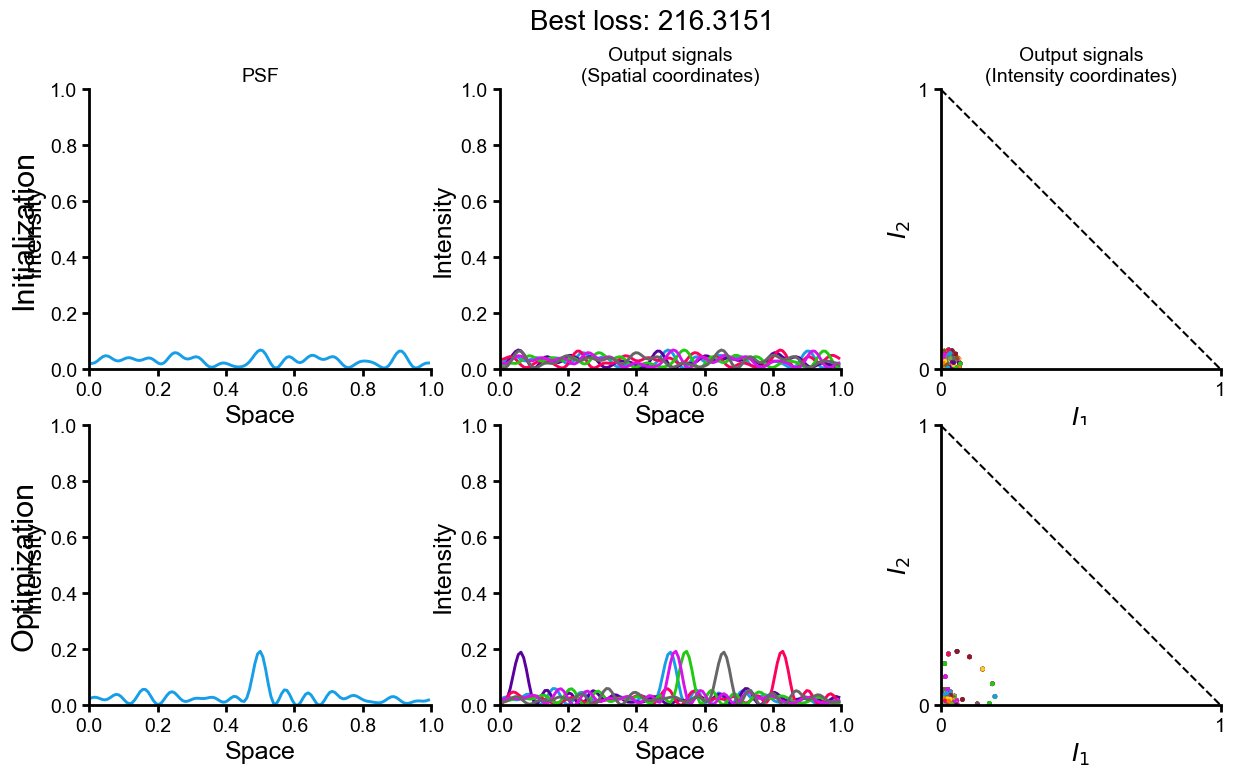

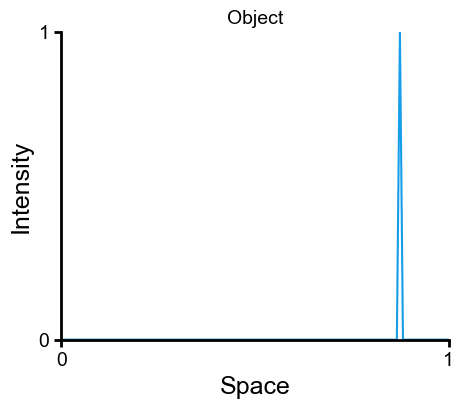

In [36]:
N_objects = 2000
N_objects_to_plot = 1
N_signals_to_plot = 6
erasure_mask = onp.ones(NUM_NYQUIST_SAMPLES)
# erasure_mask[erasure_mask.size // 4:] = 0
erasure_mask = np.array(erasure_mask, dtype=bool)
sampling_indices = (1, 2)

objects = np.array([sample_amplitude_object('delta', num_deltas=1) for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('delta', num_deltas=5) for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('pink_noise') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('white_noise') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('random_amplitude_delta') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('random_pairs') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('delta_in_some_places') for i in range(N_objects)])
# objects = np.array([sample_amplitude_object('sinusoid', sin_freq_range=(9, 10)) for i in range(N_objects)])


initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())
initial_params = np.concatenate(real_imag_params_from_signal(initial_kernel))

loss_fn = make_convolutional_forward_model_and_entropy_loss_fn_and_erasure(objects, erasure_mask)
optimized_params = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                         initial_params,
                           learning_rate=1e-4, learning_rate_decay=0.999,
                           verbose=True,
                         loss_improvement_patience=2000, max_epochs=5000)
optimized_loss = loss_fn(optimized_params)


# plot the initial and optimized convolutional encoders
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

plot_in_spatial_coordinates(ax[0, 0], initial_kernel, show_samples=False, center=True)
plot_in_spatial_coordinates(ax[1, 0], signal_from_real_imag_param_vec(optimized_params), show_samples=False, center=True)
ax[0,0].set_title('PSF')


ax[0, 0].text(-0.15, 0.5, 'Initialization', transform=ax[0, 0].transAxes,
            rotation=90, va='center', ha='right', fontsize=22)           
ax[1, 0].text(-0.15, 0.5, 'Optimization', transform=ax[1, 0].transAxes,
            rotation=90, va='center', ha='right', fontsize=22)       

# plot the output signals
plot_in_spatial_coordinates(ax[0, 1], conv_forward_model(initial_params, objects[:N_signals_to_plot], erasure_mask), show_samples=False)
plot_in_spatial_coordinates(ax[1, 1], conv_forward_model(optimized_params, objects[:N_signals_to_plot], erasure_mask), show_samples=False)
ax[0,1].set_title('Output signals\n(Spatial coordinates)')

# plot the output signals in intensity coordinates
plot_in_intensity_coordinates(ax[0, 2], conv_forward_model(initial_params, objects, erasure_mask),
                               markersize=5, differentiate_colors=True, sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1, 2], conv_forward_model(optimized_params, objects, erasure_mask),
                               markersize=5, differentiate_colors=True, sample_point_indices=sampling_indices)
ax[0,2].set_title('Output signals\n(Intensity coordinates)')
fig.suptitle(f'Best loss: {optimized_loss:.4f}', fontsize=20)


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_object(ax, objects[:N_objects_to_plot])
ax.set_title('Object')

## Erasure and the optimal PSF

0
initial loss 608.7443167759088
initial loss 55.67140657877133
-55.617766508661774
-22.21192257233885
-20.406223181295914
1
initial loss 610.951729208528
initial loss 55.60545688335388
-55.234715380443674
-20.421534825274083
-20.786467230234983
2
initial loss 607.147894185192
initial loss 55.973213471974134
-56.241954982991
-18.774437119241394
-18.986244919126236
3
initial loss 622.3593289112362
initial loss 56.353558909252925
-56.83824443965476
-18.11912746832528
-20.32821058010797
4
initial loss 610.1340799620186
initial loss 56.44644586837302
-56.45866867672746
-18.923808174943115
-20.4827983555736
5
initial loss 615.9931974538083
initial loss 56.30657933283851
-56.65843556280625
-19.6148441900513
-20.348148311016004
6
initial loss 618.6520984083427
initial loss 56.25660444272263
-57.177286716044215
-19.439483419845455
-19.997643690109705
7
initial loss 608.3991200458333
initial loss 55.861794636895596
-57.2587976415095
-21.134124665271024
-21.708661595234293
8
initial loss 617.928

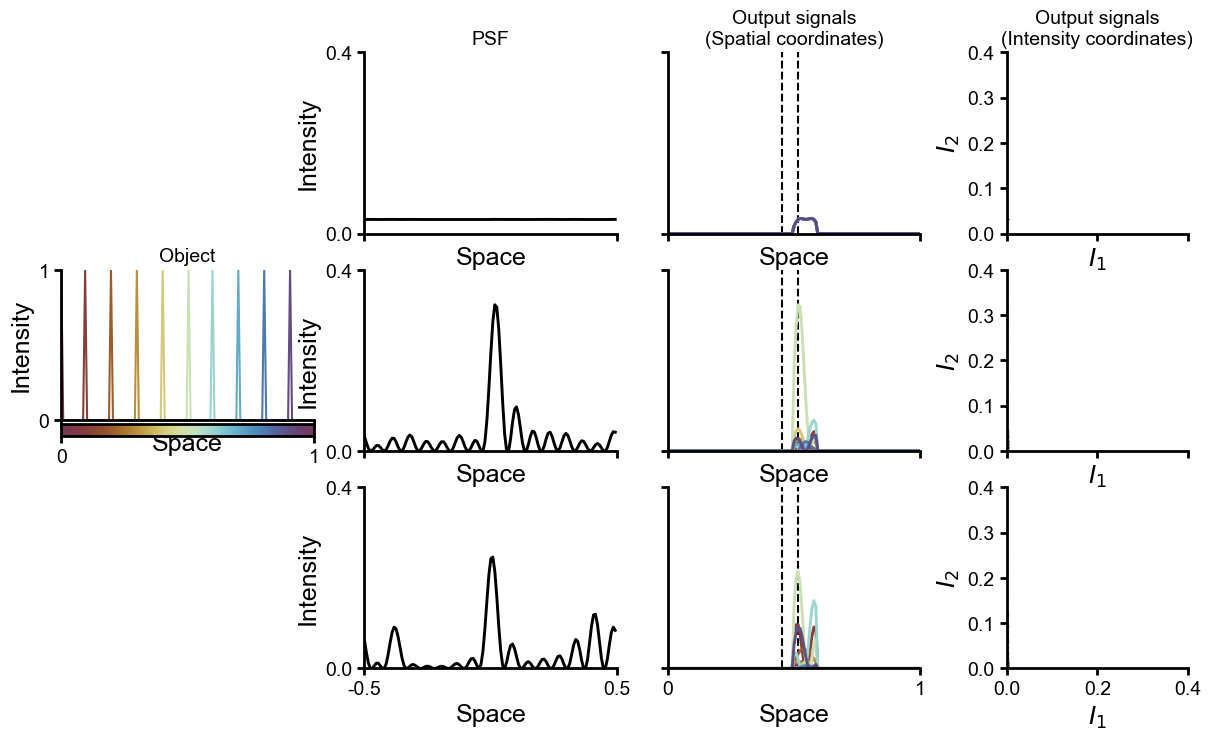

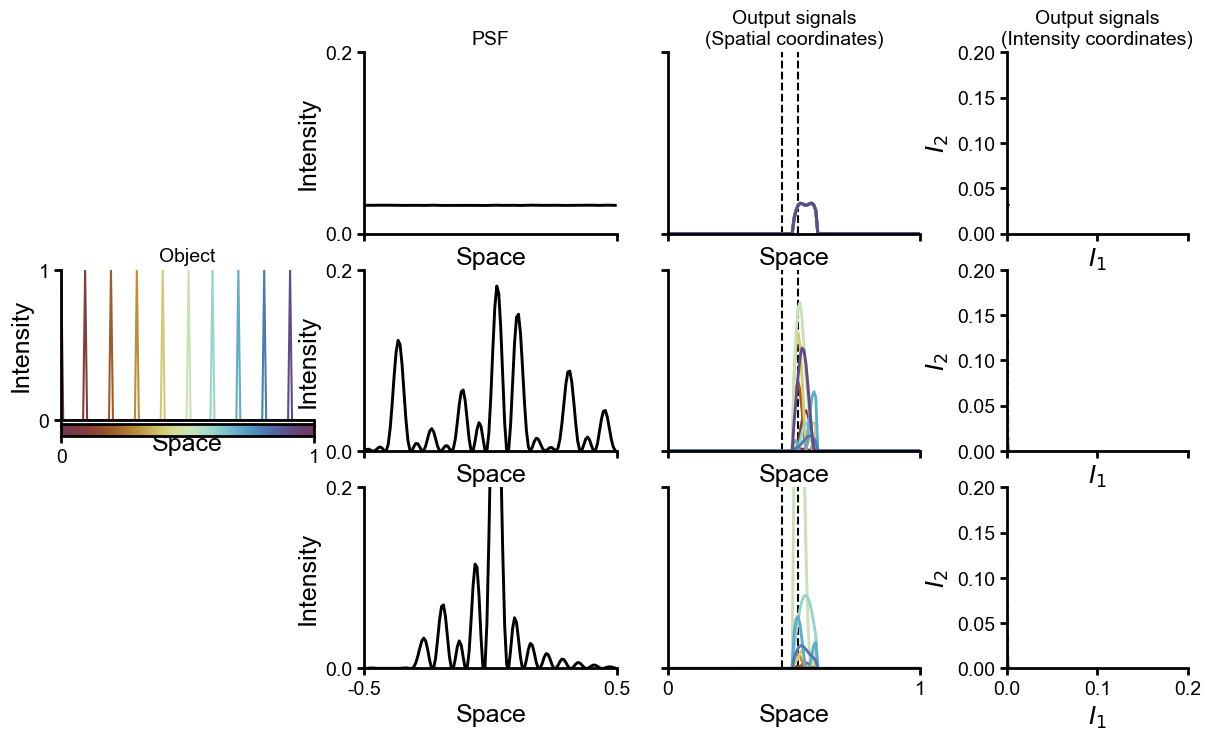

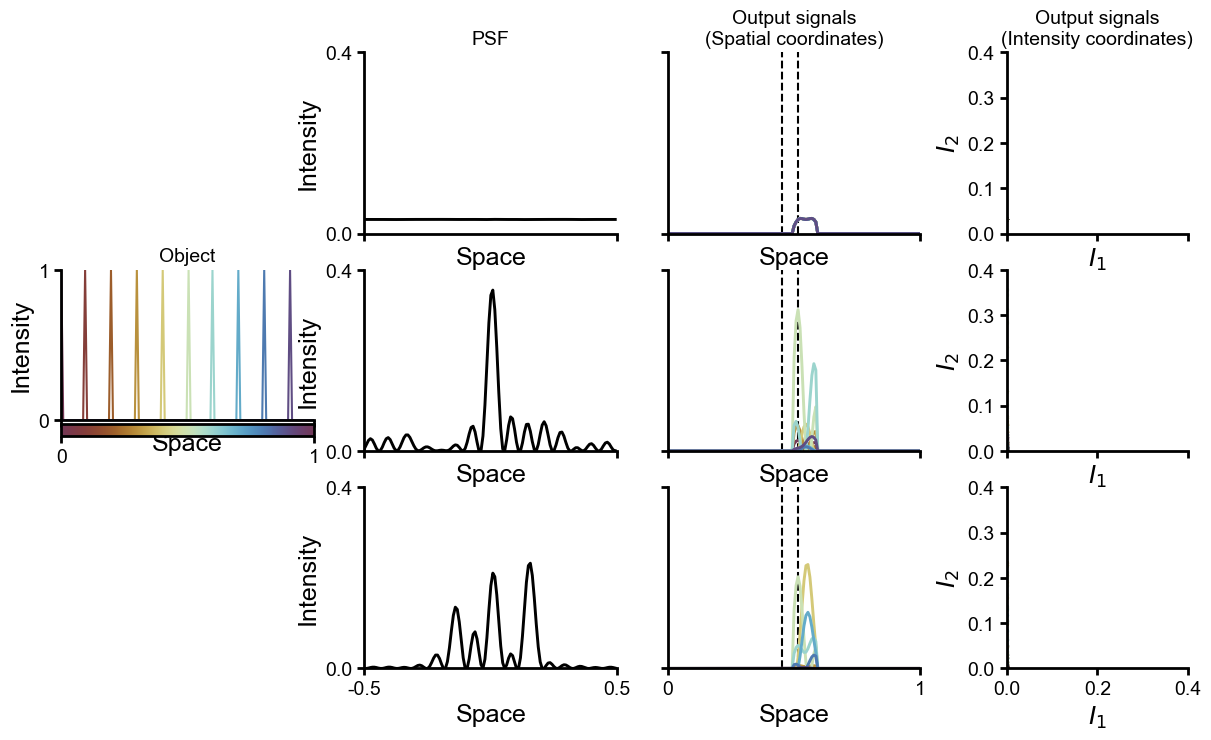

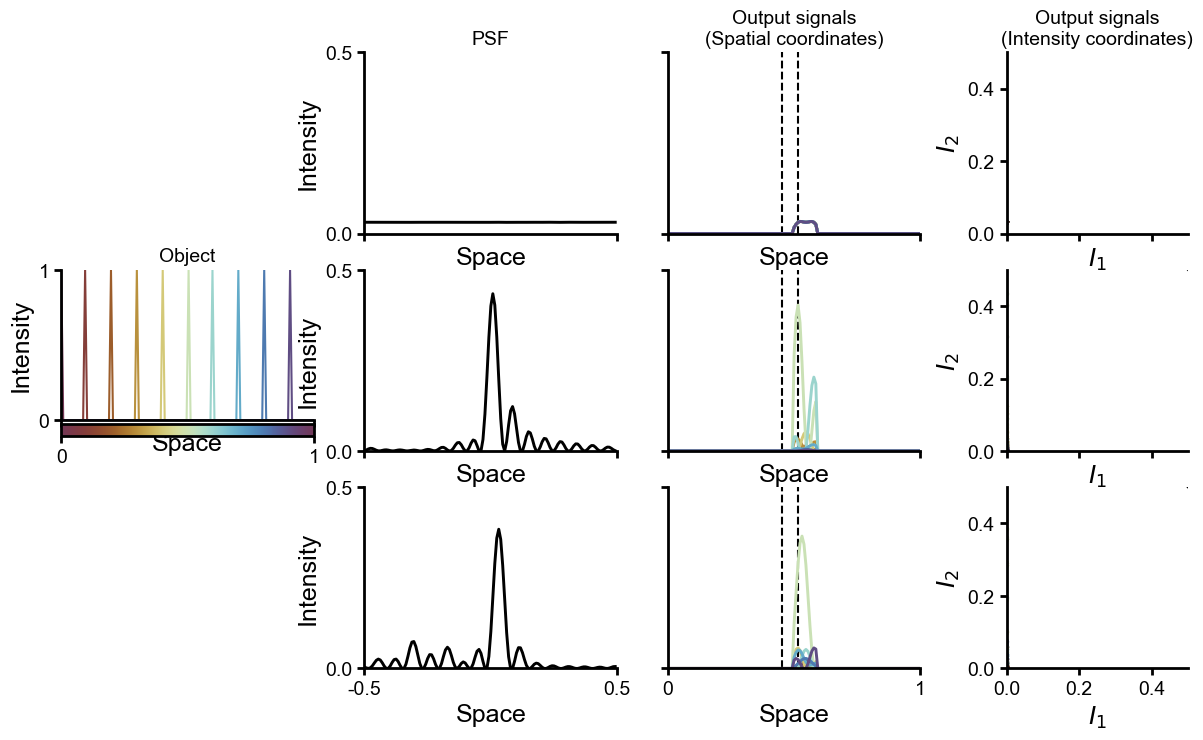

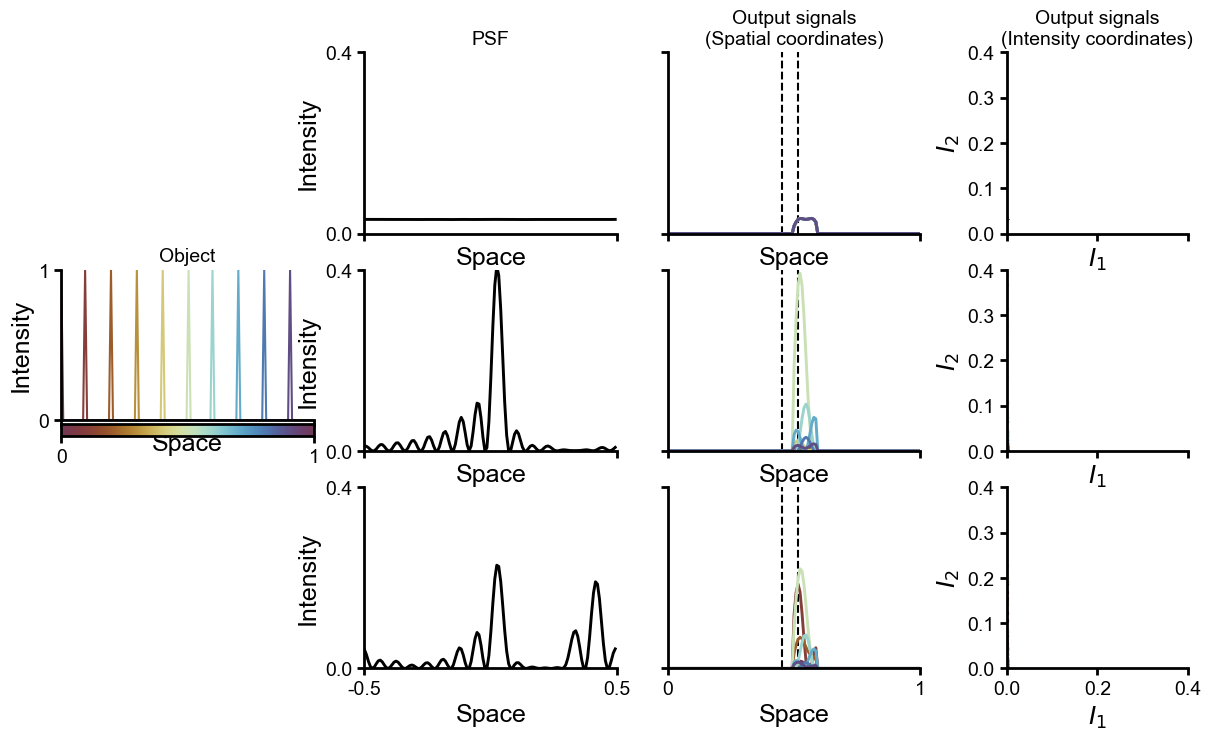

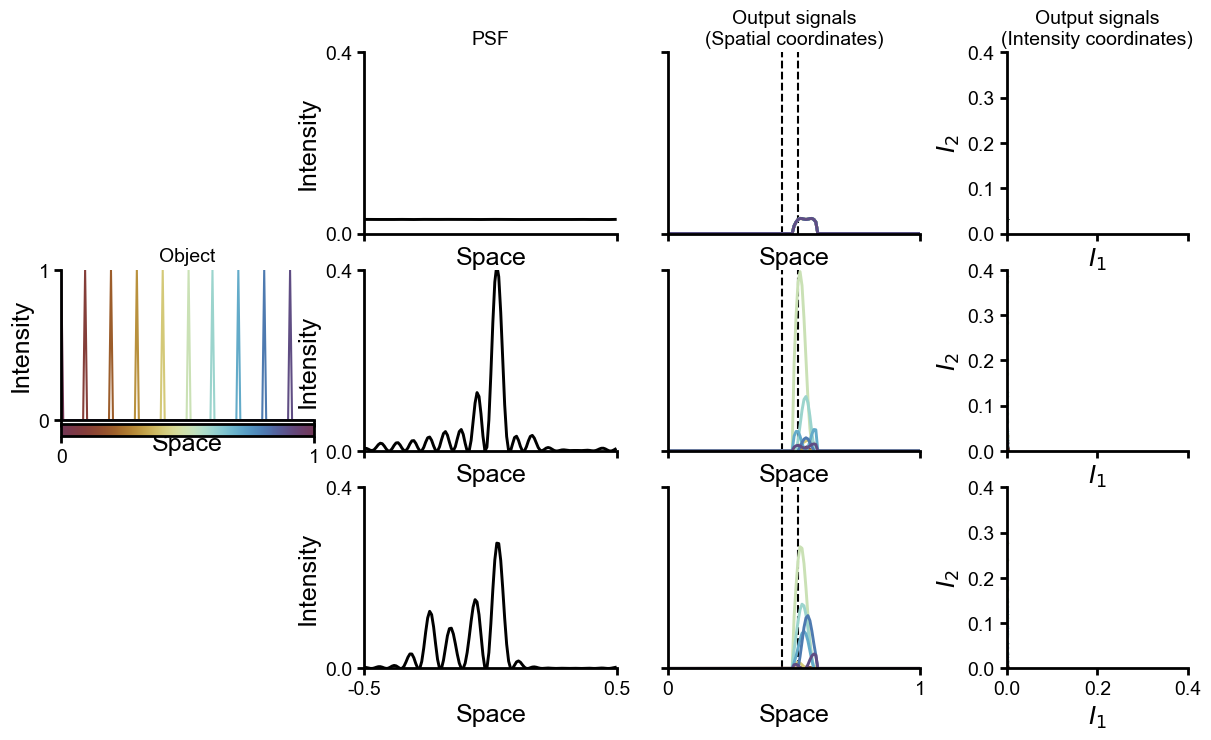

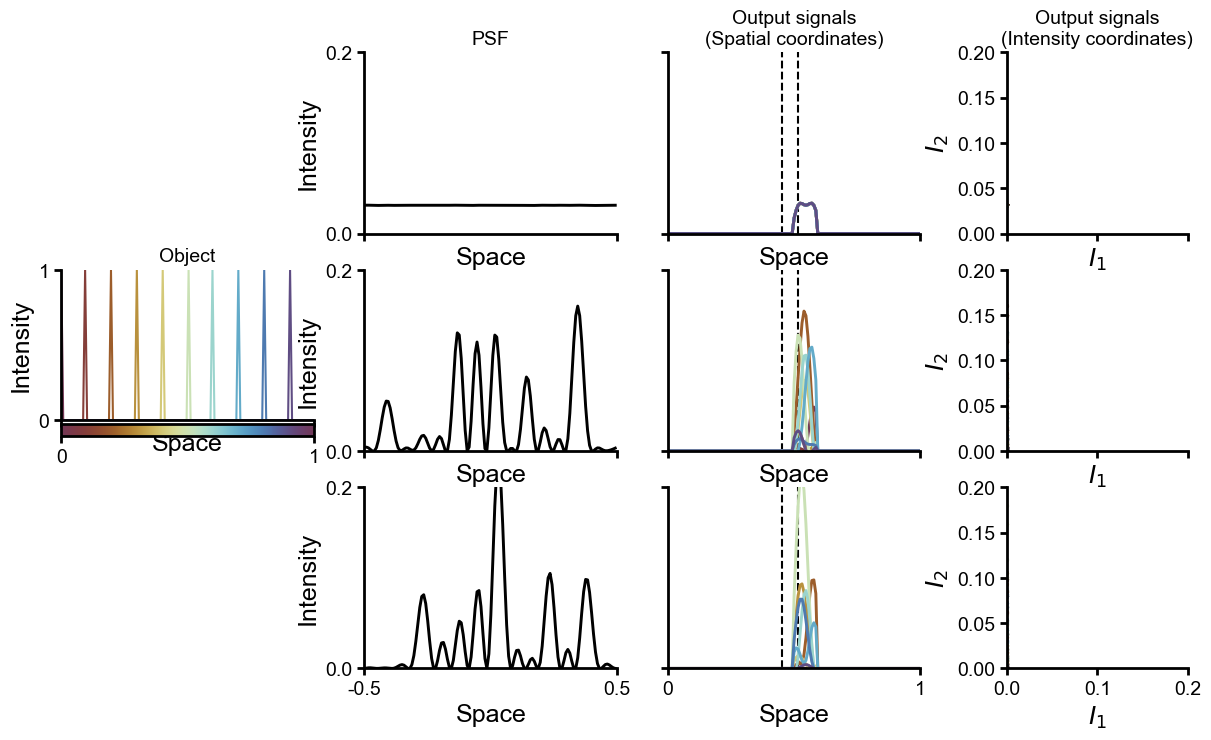

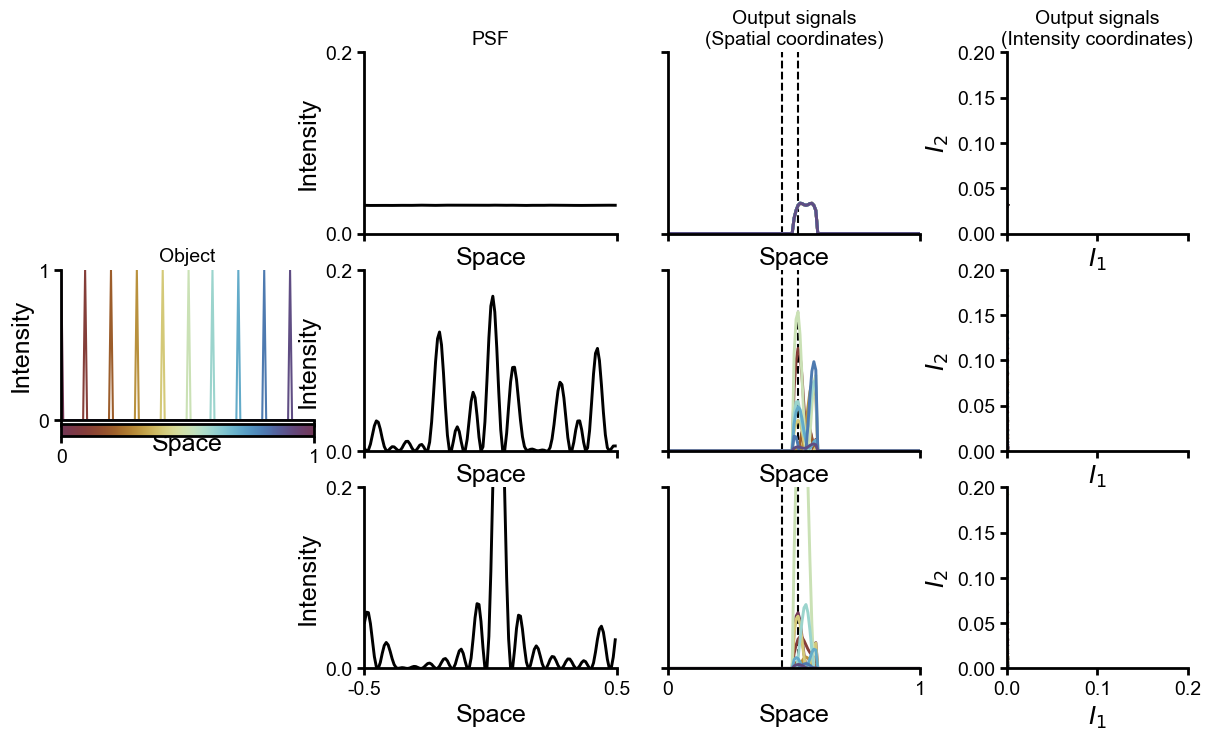

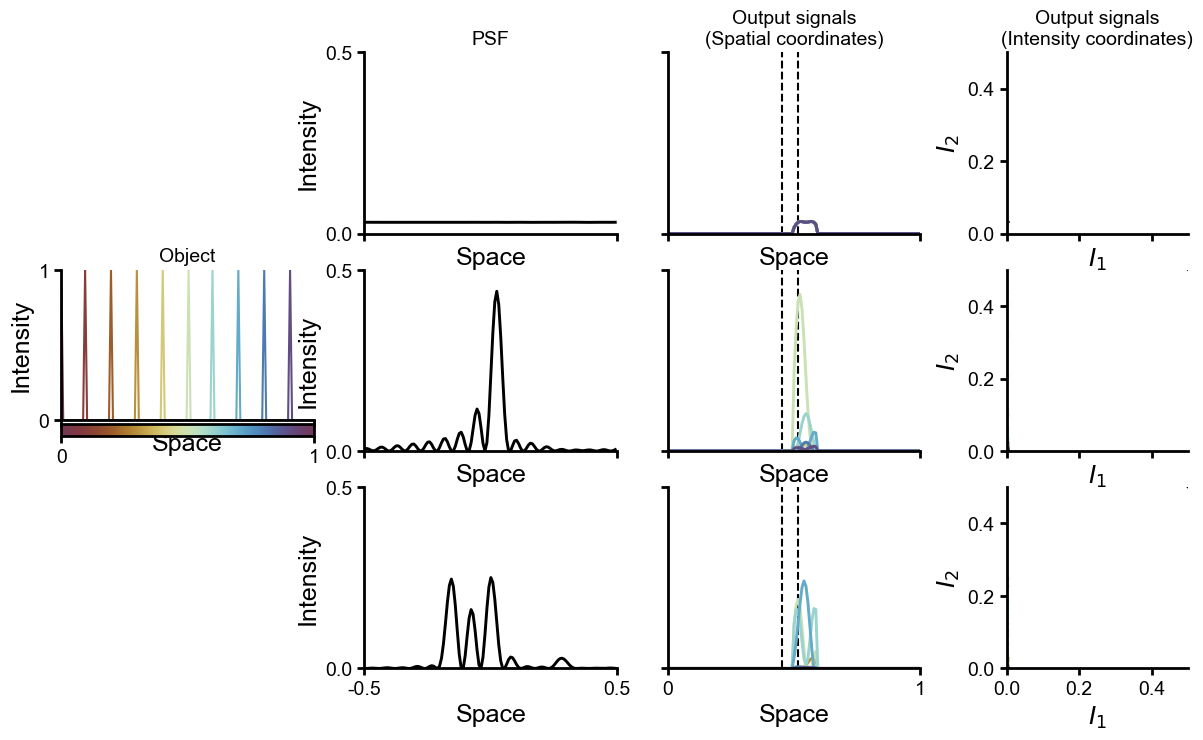

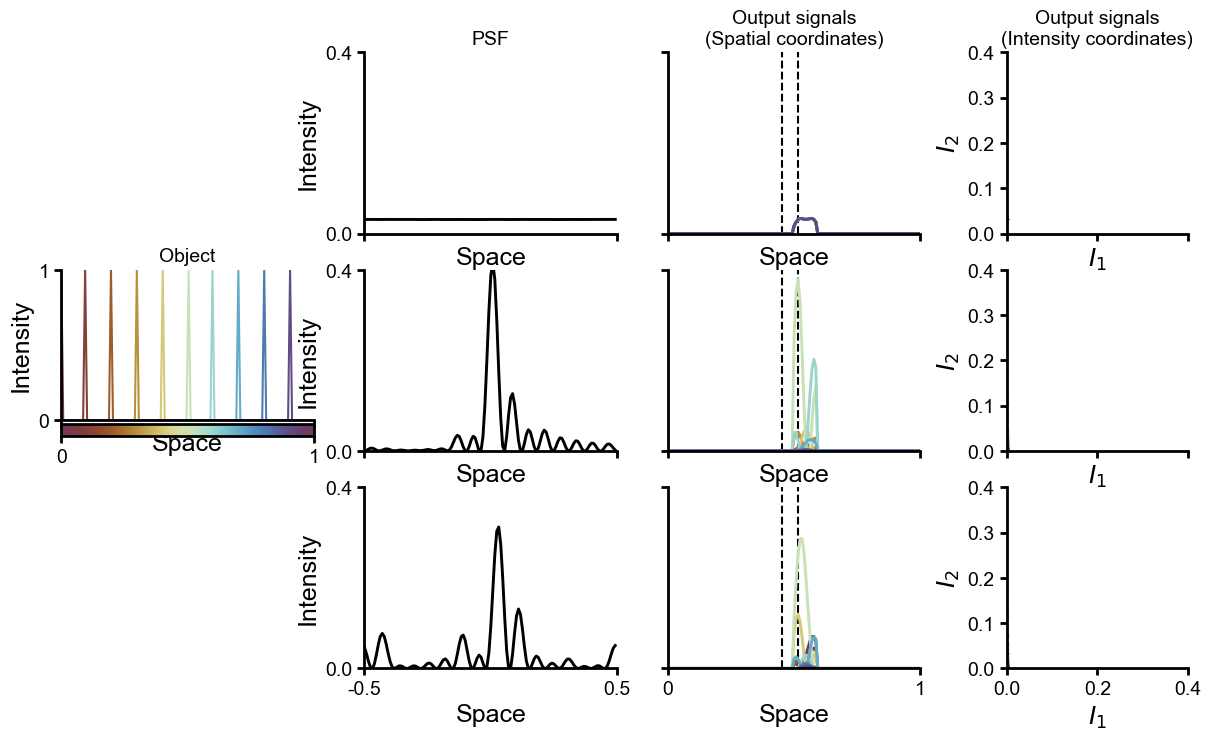

In [207]:
N_objects = 1000

for i in range(10):
  print(i)

  objects = np.array([sample_amplitude_object('delta', num_deltas=1) for i in range(N_objects)])

  # optimize with no erasure
  erasure_mask = onp.ones(NUM_NYQUIST_SAMPLES)
  erasure_mask = np.array(erasure_mask, dtype=bool)

  # initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())
  initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=np.ones(NUM_NYQUIST_SAMPLES) + onp.random.rand(NUM_NYQUIST_SAMPLES) * 0.01)
  initial_params = np.concatenate(real_imag_params_from_signal(initial_kernel))

  loss_fn = make_convolutional_forward_model_and_entropy_loss_fn_and_erasure(objects, erasure_mask)
  optimized_params_no_erasure = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                          initial_params,
                            learning_rate=1e-4, learning_rate_decay=0.999,
                            verbose=True,
                          loss_improvement_patience=2000, max_epochs=5000)
  optimized_kernel_no_erasure = signal_from_real_imag_param_vec(optimized_params_no_erasure)



  ### erase 75% of the sensor pixels
  # optimize with same init
  erasure_mask = onp.zeros(NUM_NYQUIST_SAMPLES)
  # erasure_mask[int(0.1 * erasure_mask.size): int(0.2 * erasure_mask.size)] = 1
  # erasure_mask[int(0.3 * erasure_mask.size): int(0.4 * erasure_mask.size)] = 1
  erasure_mask[int(0.5 * erasure_mask.size): int(0.6 * erasure_mask.size)] = 1
  # erasure_mask[int(0.7 * erasure_mask.size): int(0.8 * erasure_mask.size)] = 1
  # erasure_mask[int(0.9 * erasure_mask.size): int(erasure_mask.size)] = 1
  erasure_mask = np.array(erasure_mask, dtype=bool)

  loss_fn = make_convolutional_forward_model_and_entropy_loss_fn_and_erasure(objects, erasure_mask)
  optimized_params_with_erasure = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                          initial_params,
                            learning_rate=1e-4, learning_rate_decay=0.999,
                            verbose=True,
                          loss_improvement_patience=2000, max_epochs=5000)
  optimized_kernel_with_erasure = signal_from_real_imag_param_vec(optimized_params_with_erasure)



  ## shift the  kernels to be centered for beter visualization
  initial_kernel = np.roll(initial_kernel, initial_kernel.size // 2 - np.argmax(initial_kernel))
  optimized_kernel_no_erasure = np.roll(optimized_kernel_no_erasure, optimized_kernel_no_erasure.size // 2 - np.argmax(optimized_kernel_no_erasure))
  optimized_kernel_with_erasure = np.roll(optimized_kernel_with_erasure, optimized_kernel_with_erasure.size // 2 - np.argmax(optimized_kernel_with_erasure))

  initial_params_display = np.concatenate(real_imag_params_from_signal(np.fft.fftshift(initial_kernel)))
  optimized_params_no_erasure_display = np.concatenate(real_imag_params_from_signal(np.fft.fftshift(optimized_kernel_no_erasure)))
  optimized_params_with_erasure_display = np.concatenate(real_imag_params_from_signal(np.fft.fftshift(optimized_kernel_with_erasure)))



  from signal_utils_1D import *
  import cmcrameri # required in order to register the colormaps with Matplotlib
  from matplotlib.cm import ScalarMappable
  from matplotlib.colors import Normalize


  sampling_indices = (14, 16)
  N_signals_to_plot = 10


  # more objects for plotting
  objects = np.array([sample_amplitude_object('delta', num_deltas=1) for i in range(1000)])


  example_objects = onp.zeros((N_signals_to_plot, OBJECT_LENGTH))
  # make equally spaced delta functions
  for i in range(N_signals_to_plot):
      example_objects[i, i * example_objects.shape[1] // N_signals_to_plot] = 1


  fig, ax = plt.subplots(3, 4, figsize=(15, 8), sharex='col')

  ### plot delta function objects, colored by position
  colormap = plt.get_cmap('cmc.romaO')
  object_colors = [colormap((np.argmax(o) + 0.5) / o.size) for o in objects]
  example_object_colors = [colormap((np.argmax(o) + 0.5) / o.size) for o in example_objects]
  plot_object(ax[1, 0], example_objects[:N_signals_to_plot], colors=example_object_colors[:N_signals_to_plot])
  ax[0,0].axis('off')
  ax[1, 0].set_title('Object')
  ax[2, 0].axis('off')

  # show a color bar on the x axis
  x_positions = np.linspace(0, 1, 100)
  colors = colormap(x_positions) 
  norm = Normalize(vmin=min(x_positions), vmax=max(x_positions))
  scalar_mappable = ScalarMappable(norm=norm, cmap=colormap)
  cbar = fig.colorbar(scalar_mappable, ax=ax[1, 0], orientation='horizontal', pad=0.02)
  # set the tick labels of the colorbar
  cbar.set_ticks([0, 1])


  # plot the output signals
  initial_example_signals = conv_forward_model(initial_params_display, example_objects, erasure_mask, align_center=False)
  optimized_example_signals_no_erasure = conv_forward_model(optimized_params_no_erasure_display, example_objects, erasure_mask, align_center=False)
  optimized_example_signals_with_erasure = conv_forward_model(optimized_params_with_erasure_display, example_objects, erasure_mask, align_center=False)


  intensity_lim_max = optimized_example_signals_no_erasure.max()
  # ceil to the nearest .1
  intensity_lim_max = np.ceil(intensity_lim_max * 10) / 10

  plot_in_spatial_coordinates(ax[0, 1], initial_kernel, show_samples=False)
  plot_in_spatial_coordinates(ax[1, 1], optimized_kernel_no_erasure, show_samples=False)
  plot_in_spatial_coordinates(ax[2, 1], optimized_kernel_with_erasure, show_samples=False)
  ax[0, 1].set_title('PSF')
  for a in ax[:, 1]:
      a.set(yticks=[0, intensity_lim_max], ylim=[0, intensity_lim_max], xticks=[0,1], xticklabels=[-0.5, 0.5])



  plot_in_spatial_coordinates(ax[0, 2], initial_example_signals, show_samples=False, 
                              vertical_line_indices=sampling_indices, full_height_vertical_lines=True,
                              colors=example_object_colors, erasure_mask=erasure_mask)
  plot_in_spatial_coordinates(ax[1, 2], optimized_example_signals_no_erasure, show_samples=False,
                              vertical_line_indices=sampling_indices, full_height_vertical_lines=True,
                              colors=example_object_colors, erasure_mask=erasure_mask)
  plot_in_spatial_coordinates(ax[2, 2], optimized_example_signals_with_erasure, show_samples=False,
                              vertical_line_indices=sampling_indices, full_height_vertical_lines=True,
                              colors=example_object_colors, erasure_mask=erasure_mask)

  ax[0, 2].set_title('Output signals\n(Spatial coordinates)')
  for a in ax[:, 2]:
      a.set(ylabel=None, yticks=[0, intensity_lim_max], yticklabels=[], ylim=[0, intensity_lim_max], xticks=[0, 1])


  # plot all output signals in intensity coordinates
  initial_signals = conv_forward_model(initial_params_display, objects, erasure_mask, align_center=False)
  optimized_signals_no_erasure = conv_forward_model(optimized_params_no_erasure_display, objects, erasure_mask, align_center=False)
  optimized_signals_with_erasure = conv_forward_model(optimized_params_with_erasure_display, objects, erasure_mask, align_center=False)


  plot_in_intensity_coordinates(ax[0, 3], initial_signals, markersize=5, color = object_colors,
                                sample_point_indices=sampling_indices, plot_lim=intensity_lim_max)
  plot_in_intensity_coordinates(ax[1, 3], optimized_signals_no_erasure, markersize=5, color=object_colors,
                                sample_point_indices=sampling_indices, plot_lim=intensity_lim_max)                            
  plot_in_intensity_coordinates(ax[2, 3], optimized_signals_with_erasure, markersize=5, color=object_colors,
                                sample_point_indices=sampling_indices, plot_lim=intensity_lim_max)
  ax[0, 3].set_title('Output signals\n(Intensity coordinates)')


  def calc_entropy_ish(output_signals):
      mean_subtracted = output_signals.T - np.mean(output_signals.T, axis=1, keepdims=True)
      cov_mat = np.cov(mean_subtracted)
      eig_vals = np.linalg.eigvalsh(cov_mat)
      log_evs = np.log(eig_vals)
      return np.sum(log_evs)

  print(calc_entropy_ish(initial_example_signals[:, erasure_mask]))
  print(calc_entropy_ish(optimized_example_signals_no_erasure[:, erasure_mask]))
  print(calc_entropy_ish(optimized_example_signals_with_erasure[:, erasure_mask]))


## TODO: plot Eigenvalue spectrum?

In [206]:

def calc_entropy_ish(output_signals):
    mean_subtracted = output_signals.T - np.mean(output_signals.T, axis=1, keepdims=True)
    cov_mat = np.cov(mean_subtracted)
    eig_vals = np.linalg.eigvalsh(cov_mat)
    log_evs = np.log(eig_vals)
    return np.sum(log_evs)

print(calc_entropy_ish(initial_example_signals[:, erasure_mask]))
print(calc_entropy_ish(optimized_example_signals_no_erasure[:, erasure_mask]))
print(calc_entropy_ish(optimized_example_signals_with_erasure[:, erasure_mask]))


-56.14068649159874
-19.459896836919203
-19.672229649637263
